## Initial Setup

In [ ]:
## 1. Setup
!pip install transformers datasets evaluate torch scikit-learn
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.7 MB/s eta 0:00:00


In [ ]:
## 2. Imports
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
import evaluate
from sklearn.metrics import classification_report

## Dataset Load

In [ ]:
## 3. Data Loading & Exploration
dataset = load_dataset("naimul011/BanglaToxicCommentsDB", data_files=["bangla_comments.csv"])

# Inspect
print(dataset)
print(dataset['train'][0])

# Convert to pandas for exploration
df = pd.DataFrame(dataset['train'])
df.head()

README.md: 0.00B [00:00, ?B/s]

bangla_comments.csv:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 12653
    })
})
{'Unnamed: 0': 0, 'comment_text': 'ছবি টা দেখার পর বাড়া টা কেপে ওটলো😭😭😭', 'toxic': 1.0, 'severe_toxic': 1.0, 'obscene': 1.0, 'threat': 0.0, 'insult': 0.0, 'identity_hate': 0.0}


,Unnamed: 0,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,ছবি টা দেখার পর বাড়া টা কেপে ওটলো😭😭😭,1.0,1.0,1.0,0.0,0.0,0.0
1,1,পুতুলের মতো,0.0,0.0,0.0,0.0,0.0,0.0
2,2,nicher ta dekha jacche Apu 😅😅😅😅😅,1.0,1.0,1.0,0.0,0.0,0.0
3,3,ছাগলের দল ফুল ভিডিও দেখ,1.0,0.0,0.0,0.0,0.0,0.0
4,4,পুরাই আগুন 🥰🥰🥰😌,1.0,0.0,0.0,0.0,0.0,0.0


## Data exploration

Language Style Summary:
                 Count  Percentage
language_style                   
Bengali          7679       60.69
English          4954       39.15
Banglish           20        0.16


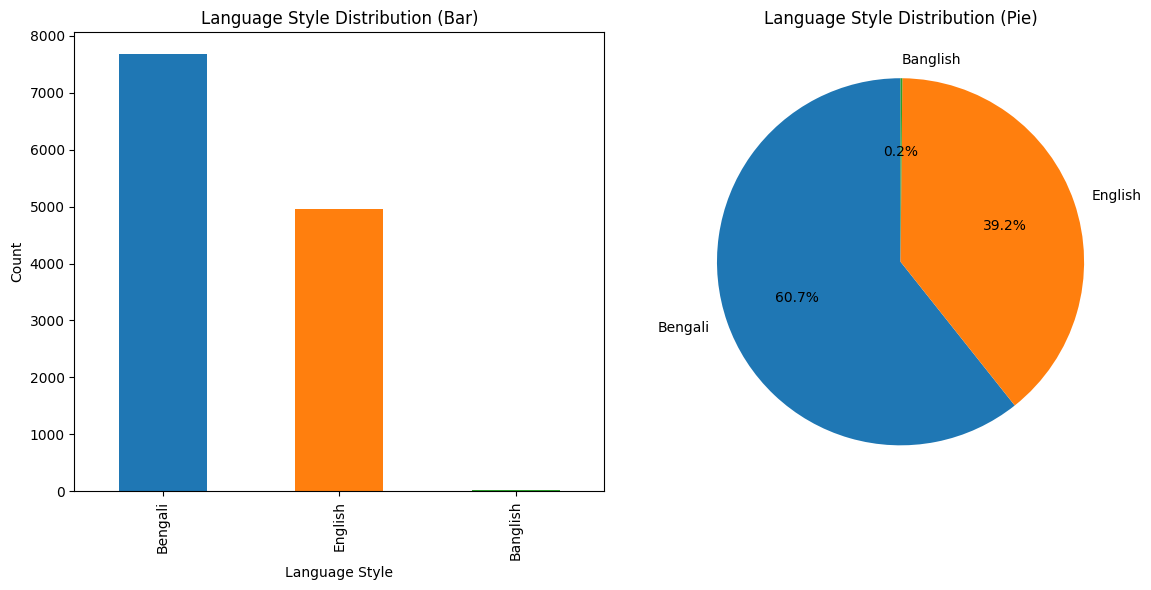

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Function to detect language style
def detect_language_style(text):
    text = str(text)
    # Bengali script check
    if re.search(r'[\u0980-\u09FF]', text):
        return "Bengali"
    # Pure English (only English chars, numbers, symbols)
    elif re.fullmatch(r'[A-Za-z0-9\s\W]+', text):
        return "English"
    # Otherwise Banglish (romanized Bangla)
    else:
        return "Banglish"

# Apply detection
df["language_style"] = df["comment_text"].apply(detect_language_style)

# Count occurrences
counts = df["language_style"].value_counts()

# Create summary DataFrame with counts + percentages
summary_df = pd.DataFrame({
    "Count": counts,
    "Percentage": (counts / counts.sum() * 100).round(2)
})

print("Language Style Summary:\n", summary_df)

# Plot bar + pie side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart
counts.plot(kind="bar", ax=axes[0], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[0].set_title("Language Style Distribution (Bar)")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Language Style")

# Pie chart
axes[1].pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90,
            colors=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[1].set_title("Language Style Distribution (Pie)")

plt.tight_layout()
plt.show()


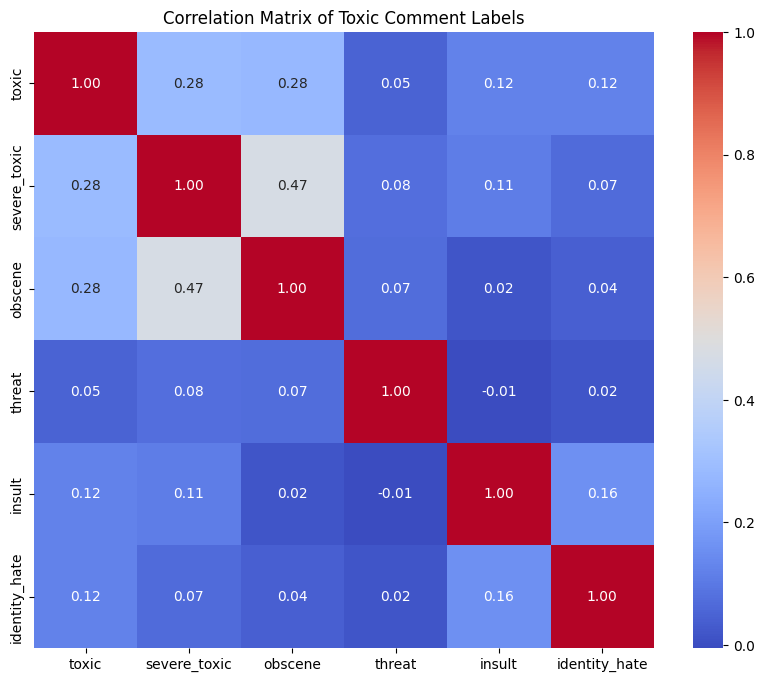

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the label columns for correlation
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
correlation_matrix = df[label_cols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Toxic Comment Labels")
plt.show()

Label Co-occurrence Summary:
------------------------------
4774 toxic comments. (37.73% of all data.)

1175 or 24.61% were also severe_toxic.
1211 or 25.37% were also obscene.
214 or 4.48% were also threat.
1279 or 26.79% were also insult.
449 or 9.41% were also identity_hate.
------------------------------
1584 severe_toxic comments. (12.52% of all data.)

1175 or 74.18% were also toxic.
883 or 55.74% were also obscene.
111 or 7.01% were also threat.
515 or 32.51% were also insult.
156 or 9.85% were also identity_hate.
------------------------------
1681 obscene comments. (13.29% of all data.)

1211 or 72.04% were also toxic.
883 or 52.53% were also severe_toxic.
112 or 6.66% were also threat.
373 or 22.19% were also insult.
136 or 8.09% were also identity_hate.
------------------------------
422 threat comments. (3.34% of all data.)

214 or 50.71% were also toxic.
111 or 26.30% were also severe_toxic.
112 or 26.54% were also obscene.
82 or 19.43% were also insult.
34 or 8.06% were a

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,4774,1175,1211,214,1279,449
severe_toxic,1175,1584,883,111,515,156
obscene,1211,883,1681,112,373,136
threat,214,111,112,422,82,34
insult,1279,515,373,82,2595,337
identity_hate,449,156,136,34,337,728



Co-occurrence Matrix (Row Percentage - % of comments with row label):


,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,100.00%,24.61%,25.37%,4.48%,26.79%,9.41%
severe_toxic,74.18%,100.00%,55.74%,7.01%,32.51%,9.85%
obscene,72.04%,52.53%,100.00%,6.66%,22.19%,8.09%
threat,50.71%,26.30%,26.54%,100.00%,19.43%,8.06%
insult,49.29%,19.85%,14.37%,3.16%,100.00%,12.99%
identity_hate,61.68%,21.43%,18.68%,4.67%,46.29%,100.00%


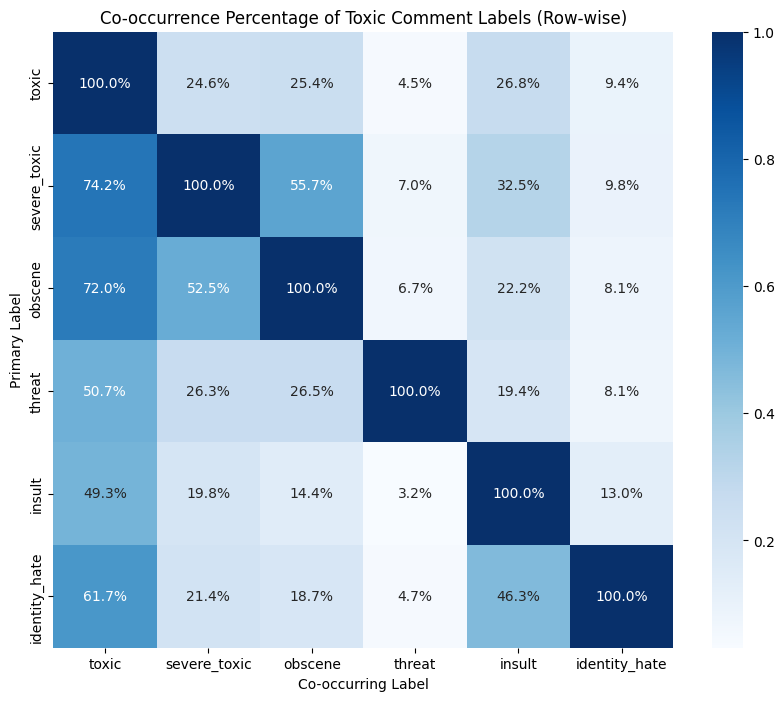

In [ ]:
# Analyze co-occurrence of labels
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
total_comments = len(df)

print("Label Co-occurrence Summary:")
print("-" * 30)

for label in label_cols:
    label_count = df[label].sum()
    print(f"{int(label_count)} {label} comments. ({label_count/total_comments:.2%} of all data.)\n")

    # Filter for comments with the current label
    subset_df = df[df[label] == 1]
    subset_count = len(subset_df)

    if subset_count > 0:
        for other_label in label_cols:
            if label != other_label:
                co_occurrence_count = subset_df[other_label].sum()
                print(f"{int(co_occurrence_count)} or {co_occurrence_count/subset_count:.2%} were also {other_label}.")
    print("-" * 30)

# Create a matrix for co-occurrence counts
co_occurrence_matrix = pd.DataFrame(index=label_cols, columns=label_cols)

for label1 in label_cols:
    for label2 in label_cols:
        if label1 == label2:
            co_occurrence_matrix.loc[label1, label2] = df[label1].sum()
        else:
            co_occurrence_matrix.loc[label1, label2] = df[(df[label1] == 1) & (df[label2] == 1)].shape[0]

# Convert to integer type for better display
co_occurrence_matrix = co_occurrence_matrix.astype(int)

print("\nCo-occurrence Matrix (Counts):")
display(co_occurrence_matrix)

# Create a matrix for co-occurrence percentages (row-wise - % of comments with label1 that also have label2)
co_occurrence_percentage_row = pd.DataFrame(index=label_cols, columns=label_cols)

for label1 in label_cols:
    for label2 in label_cols:
        subset_count = df[label1].sum()
        if subset_count > 0:
            if label1 == label2:
                co_occurrence_percentage_row.loc[label1, label2] = 1.0 # 100%
            else:
                co_occurrence_percentage_row.loc[label1, label2] = df[(df[label1] == 1) & (df[label2] == 1)].shape[0] / subset_count
        else:
            co_occurrence_percentage_row.loc[label1, label2] = 0.0 # No comments with label1

# Convert to float for display
co_occurrence_percentage_row = co_occurrence_percentage_row.astype(float)

print("\nCo-occurrence Matrix (Row Percentage - % of comments with row label):")
display(co_occurrence_percentage_row.style.format("{:.2%}"))


# Visualize the co-occurrence percentages as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_percentage_row, annot=True, cmap="Blues", fmt=".1%", annot_kws={"size": 10})
plt.title("Co-occurrence Percentage of Toxic Comment Labels (Row-wise)")
plt.xlabel("Co-occurring Label")
plt.ylabel("Primary Label")
plt.show()

## Preprocessing

### Preprocessing #01

In [ ]:
## 4. Preprocessing

# Choose a tokenizer for mBERT (first example)
model_checkpoint = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Define label columns (multi-label setup)
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Tokenization function
def preprocess(batch):
    encodings = tokenizer(batch["comment_text"], truncation=True, padding="max_length", max_length=128)
    # Handle None values in labels before converting to float
    labels = [float(batch[col]) if batch[col] is not None else 0.0 for col in label_cols]
    encodings["labels"] = labels
    return encodings

# Apply preprocessing
tokenized = dataset["train"].map(lambda x: preprocess(x), batched=False)

Map:   0%|          | 0/12653 [00:00<?, ? examples/s]

### Preprocessing #02



In [ ]:
# 4. Preprocessing (Part 2)
!pip install bnlp_toolkit

from datasets import load_dataset
import pandas as pd
import re
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords as en_stop
from bnlp.corpus import stopwords as bnlp_stop
from bangla_stemmer.stemmer.stemmer import BanglaStemmer

# Load the dataset if not already loaded
try:
    dataset
except NameError:
    dataset = load_dataset("naimul011/BanglaToxicCommentsDB", data_files=["bangla_comments.csv"])

# Convert to pandas DataFrame for this preprocessing step
df = pd.DataFrame(dataset['train'])

#Drop Null Rows
df1 = df.dropna()
df2 = df1.sample(frac=1)

#Replace String
def replace_strings(text):
    text = str(text)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F970" #love-smile emojy
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)

    text=emoji_pattern.sub(r'', text)

    return text

#Remove Pucntuations
def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

#Stopword Removal

stopword_list=[]

#Bangla Stopwords
# !pip install bnlp_toolkit # Already installed in setup cell
for word in tqdm_notebook(bnlp_stop, desc="Loading Bangla Stopwords"):
    stopword_list.append(word)

#English Stopwords
# import nltk # Already imported
# from nltk.corpus import stopwords as en_stop # Already imported
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

nltk_stopword = set(en_stop.words('english'))
for word in tqdm_notebook(nltk_stopword, desc="Loading English Stopwords"):
    stopword_list.append(word)


#Banglish_Stopwords search in dataset
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      output=output+" "+word
  else:
    output=data
  return str(output.strip())


tqdm.pandas()
temp_text = df2['comment_text']
temp_text = temp_text.progress_apply(replace_strings)
temp_text = temp_text.progress_apply(remove_punctuations)


potential_stopwords = []
for line in tqdm_notebook(temp_text, desc="Searching Potential Stopwords"):
    potential_stopwords.append(search_stopwords(line))
print(len(potential_stopwords))


def string_combine(stopword):
  final_d=""
  for item in range(len(df2)-1):
    final_d = final_d +" "+ stopword[item]
  return final_d

total_string_potential=string_combine(potential_stopwords)

def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

total_string_potential_dict=word_count(total_string_potential)

total_string_potential_df = pd.DataFrame(list(total_string_potential_dict.items()),columns = ['Word','Count'])

top500_potential_stopwords=total_string_potential_df.sort_values(by=['Count'],ascending=False).head(500)

all_potential_stopwords =list(top500_potential_stopwords.Word)

#all_potential_stopwords

#Banglish Stopwords From Dataset
banglish_stopwords = ['na','ki','er','ta','e','kore','a','ar','o','r','tor','ami','k','kotha','moto',  'ei', 'jonno','comment', 'korte',
                 'nai','akta','ekta','ai','kora','amar','theke','amr','j','ke','tomar','sob','tmi','tmr','hoy','you','hobe','naki',
                 'kichu','por','onek','kono','is','Ami','ase','nah','hoye','gula','sathe','tar','jabe','re','niye','pore','bole',
                 'tumi','onk','plz','din','ha','ache','chilo','te','mone','tui','sobai','shob','jai','koro','toh','kisu','jodi','diye',
                 'thik','ra','abar', 'or','hoi','Tor','keno','jara','je','ato','amra','koren','eta','mon','tai','kaj','Amar','der',
                 'kintu','Ki','apnr','lage','tore','dite','hok','hole','tara', 'kicu','koi','apnar','keu','dekha','korar', 'chai',
                 'hoito','ektu','are',  'oi','R',  'pare', 'tahole','amader','apni','chole','koira','tora','laglo','haste','ja',
                 'korse','den','pola','eto','aro', 'ek','kori','u','ata','thake', 'korbe',  'koto', 'kothay', 'korle']

for word in tqdm_notebook(banglish_stopwords, desc="Loading Banglish Stopwords"):
    stopword_list.append(word)

print(f"Total stopword list length before removing duplicates: {len(stopword_list)}")
banglish_stopword = list(dict.fromkeys(stopword_list))
print(f"Total stopword list length after removing duplicates: {len(banglish_stopword)}")

def stopwordRemoval(text):
  x=str(text)
  l=x.split()
  stm=[elem for elem in l if elem not in banglish_stopword] # Use the combined stopword list
  out=' '.join(stm)
  return str(out)


#Bangla Stemmer
# !pip install bangla-stemmer # Already installed in setup cell

# from bangla_stemmer.stemmer.stemmer import BanglaStemmer # Already imported


def stemming(text):
  output =''
  x=str(text)
  l=x.split()
  stmr = BanglaStemmer()
  for word in l:
    stm = stmr.stem(word)
    output=output + " " + stm
  return output.strip() # Remove leading/trailing space


#Created My Cleaner
def myCleaner(text):
  text = replace_strings(text)
  text = remove_punctuations(text)
  text = stopwordRemoval(text)
  text = stemming(text)
  return text

#Cleaning Feature Data
tqdm.pandas()
comments = df2['comment_text']
my_cleaned_comments = comments.progress_apply(myCleaner)

display(my_cleaned_comments.head())

ImportError: cannot import name 'stopwords' from 'bnlp.corpus' (/usr/local/lib/python3.12/dist-packages/bnlp/corpus/__init__.py)

## Model & Evaluation

### mBERT with Preprocessing #01

In [ ]:
## 5. Modeling – with mBERT
num_labels = len(label_cols)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

# Define evaluation metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    report = classification_report(labels, preds, target_names=label_cols, output_dict=True)
    # Macro F1 for comparison
    macro_f1 = report['macro avg']['f1-score']
    micro_f1 = report['weighted avg']['f1-score']
    return {"macro_f1": macro_f1, "micro_f1": micro_f1}

args = TrainingArguments(
    "mBERT-toxic-eval",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized.shuffle(seed=42).select(range(2000)),  # small subset for demo
    eval_dataset=tokenized.shuffle(seed=42).select(range(500)),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3707514274.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1
1,No log,0.395765,0.023810,0.054274
2,No log,0.359380,0.084325,0.192222


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

TrainOutput(global_step=250, training_loss=0.3878747863769531, metrics={'train_runtime': 5483.7382, 'train_samples_per_second': 0.729, 'train_steps_per_second': 0.046, 'total_flos': 263120504832000.0, 'train_loss': 0.3878747863769531, 'epoch': 2.0})

In [ ]:
# ## 6. Evaluation
# results = trainer.evaluate()
# print("Evaluation Results:", results)

# # Full classification report
# preds = trainer.predict(tokenized.shuffle(seed=42).select(range(500)))
# y_true = preds.label_ids
# probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
# y_pred = (probs > 0.5).astype(int)

# print(classification_report(y_true, y_pred, target_names=label_cols))

## 6. Evaluation
results = trainer.evaluate()
print("Evaluation Results:", results)

# Full classification report
preds = trainer.predict(tokenized.shuffle(seed=42).select(range(500)))
y_true = preds.label_ids

# Probabilities from logits
probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
y_pred = (probs > 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=label_cols))

# --- Extra standard metrics ---
from sklearn.metrics import accuracy_score, hamming_loss, roc_auc_score, f1_score

# Subset Accuracy (exact match)
subset_acc = accuracy_score(y_true, y_pred)
print("Subset Accuracy:", subset_acc)

# Hamming Loss
hl = hamming_loss(y_true, y_pred)
print("Hamming Loss:", hl)

# F1 Scores
f1_micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)

# ROC-AUC (micro & macro)
try:
    roc_micro = roc_auc_score(y_true, probs, average="micro")
    roc_macro = roc_auc_score(y_true, probs, average="macro")
    print("ROC-AUC (Micro):", roc_micro)
    print("ROC-AUC (Macro):", roc_macro)
except Exception as e:
    print("ROC-AUC could not be calculated:", e)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Evaluation Results: {'eval_loss': 0.3593798279762268, 'eval_macro_f1': 0.08432539682539682, 'eval_micro_f1': 0.192222065991751, 'eval_runtime': 181.687, 'eval_samples_per_second': 2.752, 'eval_steps_per_second': 0.176, 'epoch': 2.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

               precision    recall  f1-score   support

        toxic       0.59      0.44      0.51       193
 severe_toxic       0.00      0.00      0.00        69
      obscene       0.00      0.00      0.00        70
       threat       0.00      0.00      0.00        17
       insult       0.00      0.00      0.00       121
identity_hate       0.00      0.00      0.00        38

    micro avg       0.59      0.17      0.26       508
    macro avg       0.10      0.07      0.08       508
 weighted avg       0.23      0.17      0.19       508
  samples avg       0.17      0.08      0.11       508

Subset Accuracy: 0.418
Hamming Loss: 0.16033333333333333
F1 Score (Micro): 0.261136712749616
F1 Score (Macro): 0.08432539682539682
ROC-AUC (Micro): 0.818758610229901
ROC-AUC (Macro): 0.7578906587986327


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

### Another model & Evaluation

In [ ]:
## 7. Comparative Experiments
Repeat **Section 5 & 6** with different models (e.g. `xlm-roberta-base`, `ai4bharat/indic-bert`, `google/muril-base-cased`, `bigscience/bloomz-560m`). Keep the same `compute_metrics` so evaluation is consistent.



SyntaxError: invalid decimal literal (ipython-input-488220466.py, line 2)

In [ ]:
## 8. Results Comparison Table
```python
# After running multiple models, log results into a DataFrame
comparison = pd.DataFrame([
    {"Model": "mBERT", "Macro F1": results["eval_macro_f1"], "Micro F1": results["eval_micro_f1"]},
    # add rows for other models
])

comparison
```

---

## 9. Conclusion & Next Steps
- Which model performs best?
- Are there trade-offs in speed vs accuracy?
- Plan how to adapt or fine-tune for Bangla specifically.


SyntaxError: invalid syntax (ipython-input-698440747.py, line 2)

In [ ]:
print(tokenized)
print(tokenized[0]['labels'])
print(type(tokenized[0]['labels']))
print(type(tokenized[0]['labels'][0]))

NameError: name 'tokenized' is not defined

## Combined Evaluation


,Model,Accuracy (%),Macro F1,Micro F1,Notes
0,Logistic Regression,68.47,0.436,NaN,Struggled on rare classes
1,Naive Bayes,64.99,0.358,NaN,Fastest but weak on imbalanced labels
2,Random Forest,75.46,0.581,NaN,Best classical baseline
3,Linear SVM,69.19,0.468,NaN,Better balance across labels than LR
4,MLP Classifier,74.00,0.564,NaN,Computationally expensive
5,mBERT,41.80,0.084,0.261,ROC-AUC >0.75 but poor label-wise F1
6,BiLSTM (epoch 5),76.39,0.672,0.806,Strong early performance
7,BiLSTM (epoch 10),93.64,0.949,0.958,Best performing model


/tmp/ipython-input-2295862694.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Macro F1', y='Model', data=comparison_df.sort_values('Macro F1', ascending=False), palette='viridis')


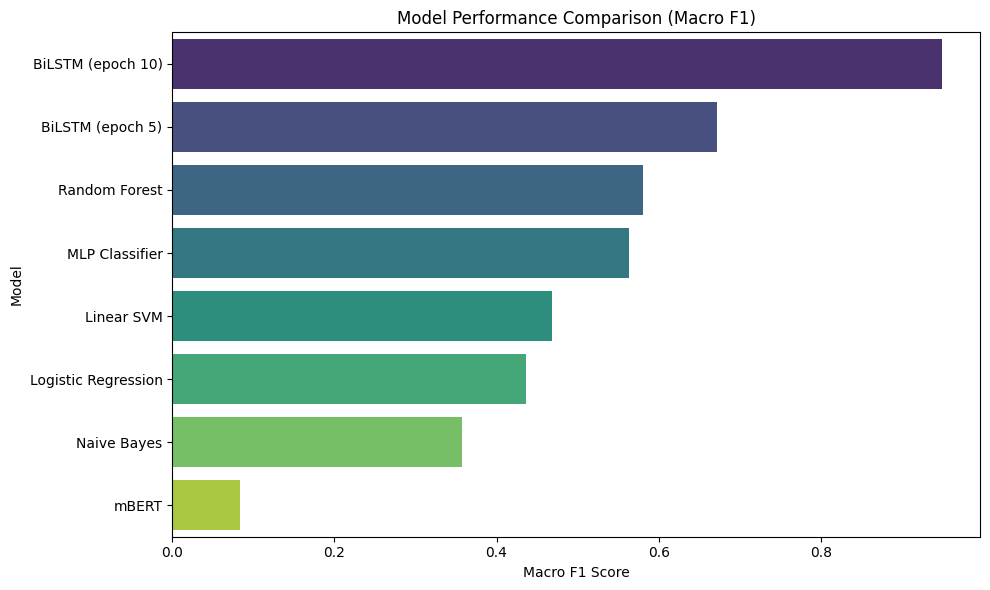

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with the provided data
data = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Linear SVM', 'MLP Classifier', 'mBERT', 'BiLSTM (epoch 5)', 'BiLSTM (epoch 10)'],
    'Accuracy (%)': [68.47, 64.99, 75.46, 69.19, 74.00, 41.80, 76.39, 93.64],
    'Macro F1': [0.436, 0.358, 0.581, 0.468, 0.564, 0.084, 0.672, 0.949],
    'Micro F1': [None, None, None, None, None, 0.261, 0.806, 0.958],
    'Notes': ['Struggled on rare classes', 'Fastest but weak on imbalanced labels', 'Best classical baseline', 'Better balance across labels than LR', 'Computationally expensive', 'ROC-AUC >0.75 but poor label-wise F1', 'Strong early performance', 'Best performing model']
}

comparison_df = pd.DataFrame(data)

# Display the comparison table
display(comparison_df)

# Plot the Macro F1 scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Macro F1', y='Model', data=comparison_df.sort_values('Macro F1', ascending=False), palette='viridis')
plt.title('Model Performance Comparison (Macro F1)')
plt.xlabel('Macro F1 Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# You can similarly plot other metrics like Accuracy or Micro F1 if needed
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Accuracy (%)', y='Model', data=comparison_df.sort_values('Accuracy (%)', ascending=False), palette='viridis')
# plt.title('Model Performance Comparison (Accuracy)')
# plt.xlabel('Accuracy (%)')
# plt.ylabel('Model')
# plt.tight_layout()
# plt.show()

/tmp/ipython-input-4172675167.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy (%)', y='Model', data=comparison_df.sort_values('Accuracy (%)', ascending=False), palette='viridis')


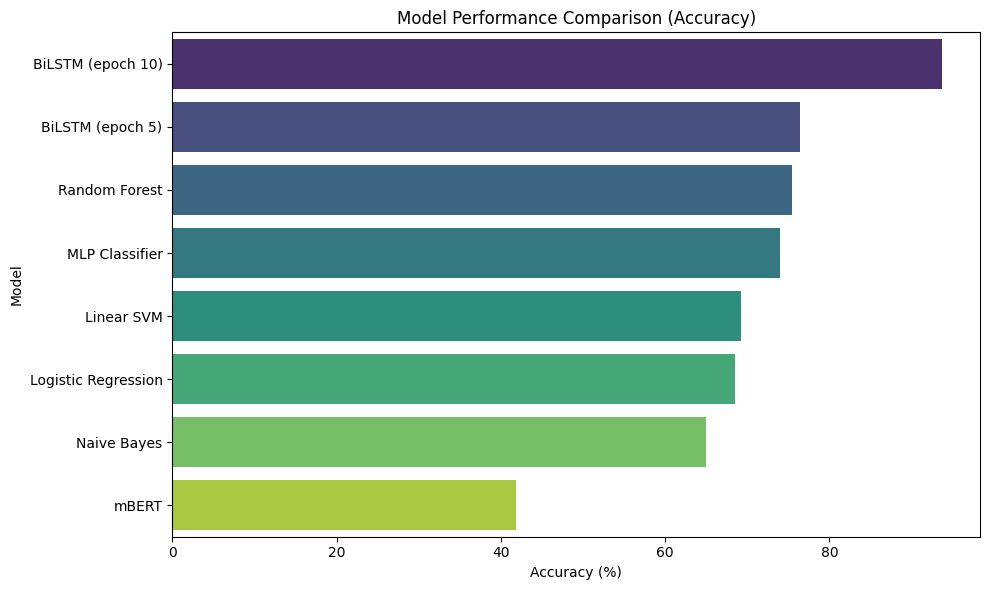

/tmp/ipython-input-4172675167.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Micro F1', y='Model', data=comparison_df.sort_values('Micro F1', ascending=False), palette='viridis')


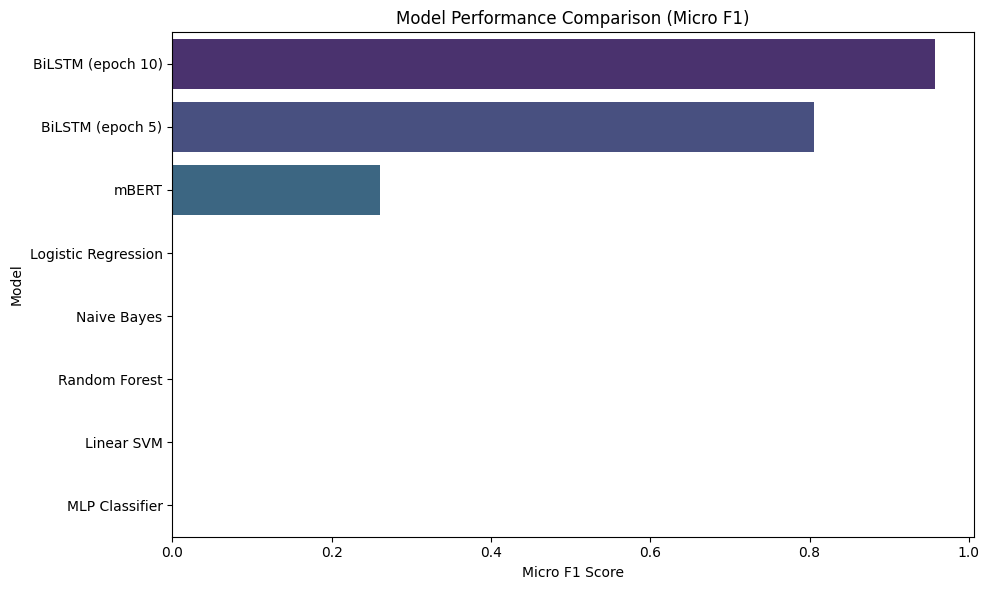

In [ ]:
# Plot the Accuracy scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy (%)', y='Model', data=comparison_df.sort_values('Accuracy (%)', ascending=False), palette='viridis')
plt.title('Model Performance Comparison (Accuracy)')
plt.xlabel('Accuracy (%)')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# Plot the Micro F1 scores (if available)
if comparison_df['Micro F1'].notna().any():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Micro F1', y='Model', data=comparison_df.sort_values('Micro F1', ascending=False), palette='viridis')
    plt.title('Model Performance Comparison (Micro F1)')
    plt.xlabel('Micro F1 Score')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()
else:
    print("Micro F1 data is not available for all models in the comparison table.")

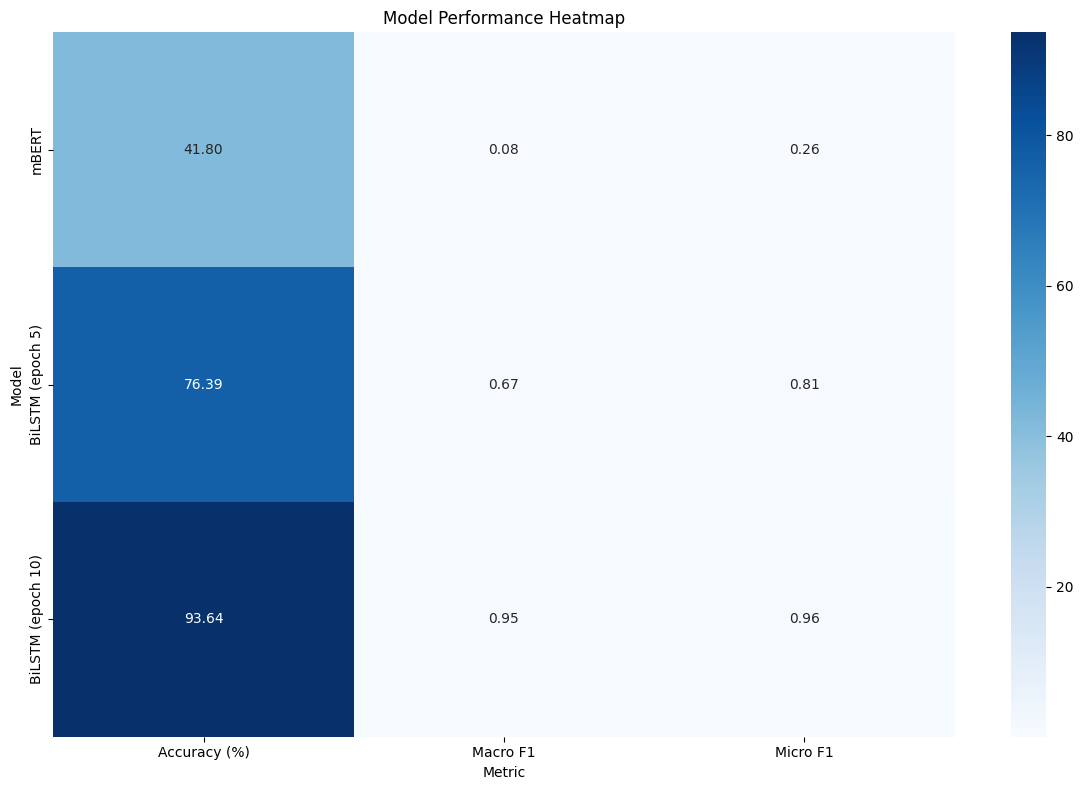

In [ ]:
# Create a heatmap for comprehensive performance comparison
plt.figure(figsize=(12, 8))
# Select only models with non-null Micro F1 for a cleaner heatmap
heatmap_data = comparison_df.set_index('Model')[['Accuracy (%)', 'Macro F1', 'Micro F1']].dropna()

sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt=".2f") # Using 'Blues' colormap as an alternative
plt.title('Model Performance Heatmap')
plt.xlabel('Metric')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# You could also try other colormaps like 'YlGnBu', 'PuRd', 'OrRd' depending on preference.
# plt.figure(figsize=(12, 8))
# sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f")
# plt.title('Model Performance Heatmap (YlGnBu)')
# plt.xlabel('Metric')
# plt.ylabel('Model')
# plt.tight_layout()
# plt.show()